In [26]:
from __future__ import print_function
from pylab import *

%matplotlib inline

import skimage 
from skimage import img_as_float
from skimage.color import rgb2gray
from skimage.exposure import * 
from skimage.filters import threshold_otsu

import numpy as np
import pandas as pd

from pytesseract import pytesseract


Image dimensions : (790, 1486, 3)
Max image value : 217


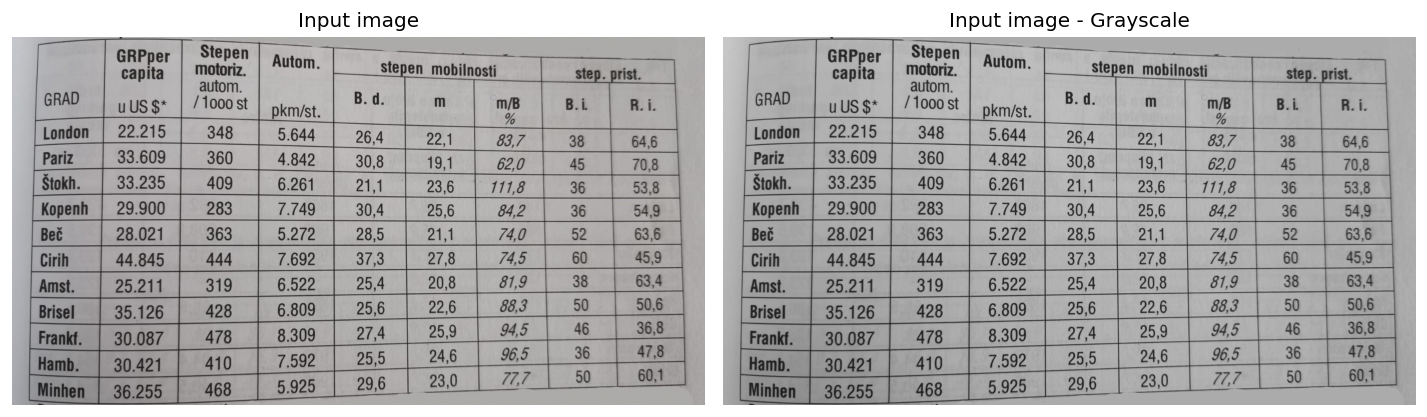

In [19]:
img = imread('img.jpeg')

img_dimensions = shape(img)
print('Image dimensions : ' + str(img_dimensions))
print('Max image value : ' + str(img.flatten().max()))

img = img/255.0

img_gray = rgb2gray(img)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 12), dpi = 120)

ax[0].imshow(img, cmap='jet',  vmin = 0, vmax = 1);
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(img_gray, cmap='gray', vmin = 0, vmax = 1);
ax[1].set_title('Input image - Grayscale')
ax[1].set_axis_off()

plt.tight_layout()
plt.show()

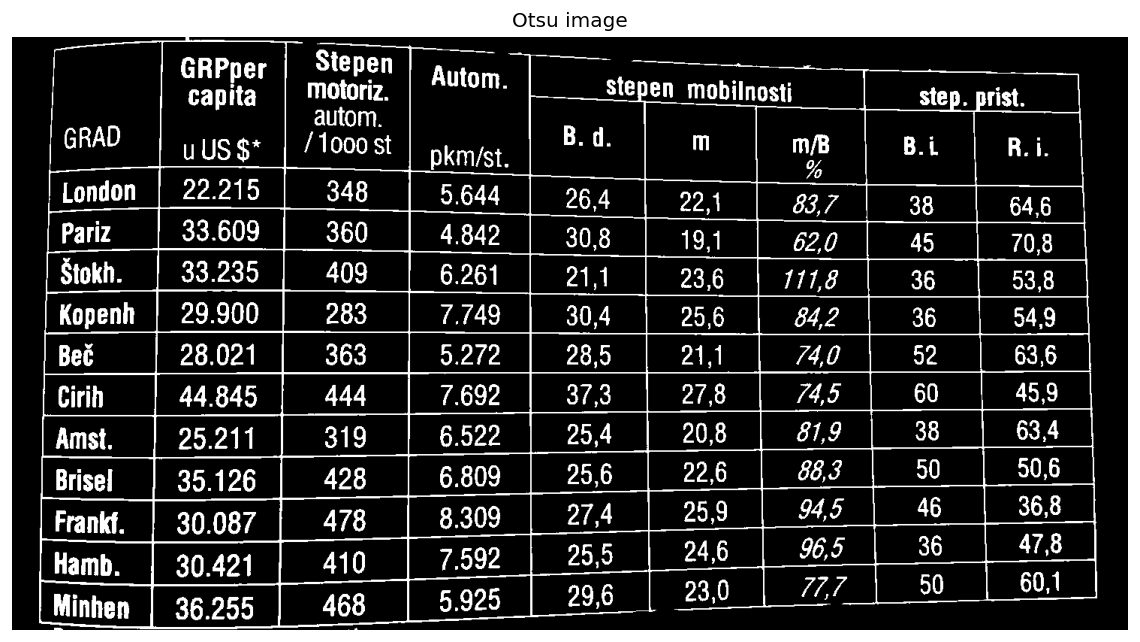

In [25]:
t_otsu = threshold_otsu(img_gray)
img_otsu = img_gray < t_otsu

figure(figsize = (12, 12), dpi = 120);
imshow(img_otsu, cmap='gray',  vmin = 0, vmax = 1);
plt.title('Otsu image')
plt.axis('off')
plt.show();